In [19]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

In [20]:
save_folder = "./visualization/"
dde.config.set_default_float("float64")
origin_ns = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])

Set the default float type to float64


In [21]:
def plot_2d(x, y, solution, title):
    plt.scatter(x, y, c=solution, cmap='viridis')
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    # Add a colorbar
    plt.colorbar()
    # Show the plot
    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

def contour_plot(X, Y, Z, title):
    plt.style.use('_mpl-gallery-nogrid')
    levels = np.linspace(np.min(Z), np.max(Z), 25)
    # plot
    fig, ax = plt.subplots()
    ax.plot(X, Y, 'o', markersize=2, color='lightgrey')
    ax.tricontour(X, Y, Z, levels=levels)

    ax.set(xlim=(-3, 3), ylim=(-3, 3))

    plt.show()
    plt.savefig(save_folder + title)
    plt.close()

In [22]:
def exact_sol(f):
    ns = origin_ns
    x = f[:, 0:1]
    y = f[:, 1:2]
    return np.sin(ns[0]*np.pi*(x + 1)*0.5)*np.sin(ns[1]*np.pi*(y + 1)*0.5)

In [23]:
# def pde(netw_in, netw_out, n1, n2):
#     dy_xx = dde.grad.hessian(netw_out, netw_in, i=0, j=0)
#     dy_yy = dde.grad.hessian(netw_out, netw_in, i=1, j=1)
#     return 0.5*(dy_xx + dy_yy)+(n1**2+n2**2)*(np.pi**2)*netw_out/8

def pde(x, psi,n1,n2):
    laplacian = dde.grad.hessian(psi, x, i=0, j=0) + dde.grad.hessian(psi, x, i=1, j=1)
    V = (n1**2 + n2**2) * np.pi**2 / (2 * 2**2)
    return 1/2 * laplacian + V * psi

def boundary(_, on_boundary):
    return on_boundary

In [24]:
def generate_test_data(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    test_x, test_y = np.meshgrid(x, y)
    test_x = test_x.reshape(-1)
    test_y = test_y.reshape(-1)
    return np.vstack((test_x, test_y)).T
    

def get_solution(data,model):
    solution = np.hstack([model.predict(el) for el in data])
    return solution

def graph_shreodinger(x,y,z,title,fig,ax,i,j):
    fig.set_size_inches(10, 10)
    fig.suptitle(title)
    contour = ax[i][j].tricontour(x, y, z)
    ax[i][j].clabel(contour, inline=1, fontsize=10)

def initial_points(points, values):
    tps = []
    for i in range(len(points)):
        tp = dde.PointSetBC(points[i], values[i])
        tps.append(tp)
    return tps

def get_value(points,n1,n2):
    tmp1 = np.sin(n1 * np.pi * (points[:, :, 0] + 1) / 2)
    tmp2 = np.sin(n2 * np.pi * (points[:, :, 1] + 1 ) / 2)
    res = tmp1 * tmp2
    return res.reshape(1, -1)[0]

Compiling model...
'compile' took 0.000265 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.33e-01, 1.86e-03]    [4.33e-01, 1.86e-03]    [9.88e-01]    
1000      [5.37e-08, 9.88e-05]    [5.37e-08, 9.88e-05]    [9.30e-01]    
2000      [2.65e-09, 2.33e-05]    [2.65e-09, 2.33e-05]    [9.29e-01]    

Best model at step 2000:
  train loss: 2.33e-05
  test loss: 2.33e-05
  test metric: [9.29e-01]

'train' took 17.557886 s

[-0.04205384 -0.03442942 -0.02747449 ...  0.00607458  0.00890122
  0.0121909 ]
[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


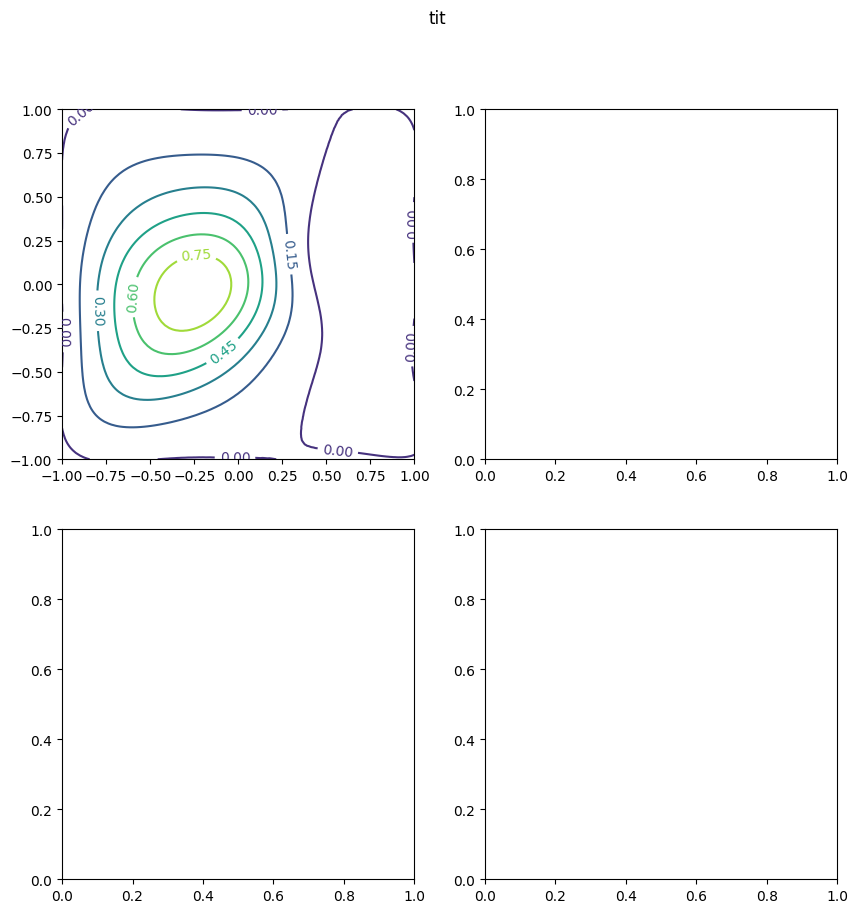

In [25]:
geom = dde.geometry.Rectangle([-1, -1], [1, 1])
# bc = dde.icbc.DirichletBC(geom, lambda _: 0, boundary)
bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary)
conditions = []
sols = []
spaces = []
for ns in [[1,1]]:
# for ns in origin_ns:
    new_pde = partial(pde,n1=ns[0],n2=[ns[1]])
    points = np.array([[[-0.5, 0]]])
    values = get_value(points,1,1)
    tps = initial_points(points, values)
    for tp in tps:
        conditions.append(tp)
    conditions.append(bc)
    data = dde.data.PDE(
        geom, 
        new_pde, 
        conditions, 
        num_domain = 800,
        num_boundary = 100,
        num_test=10**3,
        solution=exact_sol,
    )
    layer_size = [2] + [20] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot normal"

    net = dde.maps.FNN(layer_size, activation, initializer)

    # net.apply_output_transform(transform)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=2000)
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10, 10)
    test_domain = generate_test_data(100)
    predicted_solution = get_solution(test_domain,model)
    graph_shreodinger(test_domain[:,0],test_domain[:,1],predicted_solution,"tit",fig,ax,0,0)
    print(predicted_solution)
    print(test_domain)
    sols.append(predicted_solution)
    spaces.append(test_domain)

# print(sols)
# print(spaces)
# graph_shreodinger(spaces, sols, "predicted solution")

# exact_solution = np.hstack([exact_sol(el,origin_ns) for el in test_domain])
# graph_shreodinger(test_domain, exact_solution, "exact solution")

# error_l2 = (np.abs(predicted_solution - exact_solution)/exact_solution)**2
# graph_shreodinger(test_domain, exact_solution, "l2 relative error")